Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Valeurs manquantes par colonne :
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Données standardisées et enrichies :
   Gender       Age  Annual Income (k$)  Spending Score (1-100)  \
0    Male -1.424569           -1.738999               -0.434801   
1    Male -1.281035           -1.738999                1.195704   
2  Female -1.352802           -1.700830               -1.715913   
3  Female -1.137502           -1.700830                1.040418   
4  Female -0.563369           -1.662660               -0.395980   

   AgeGroup_Jeune adulte  AgeGroup_Adulte  AgeGroup_Senior  
0                  False            False            False  
1                   True            False            False  
2                   True            False            False  

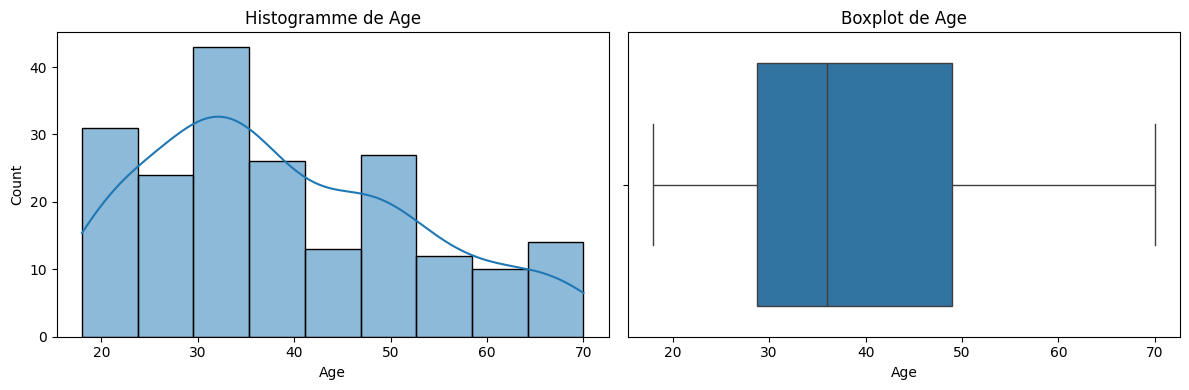

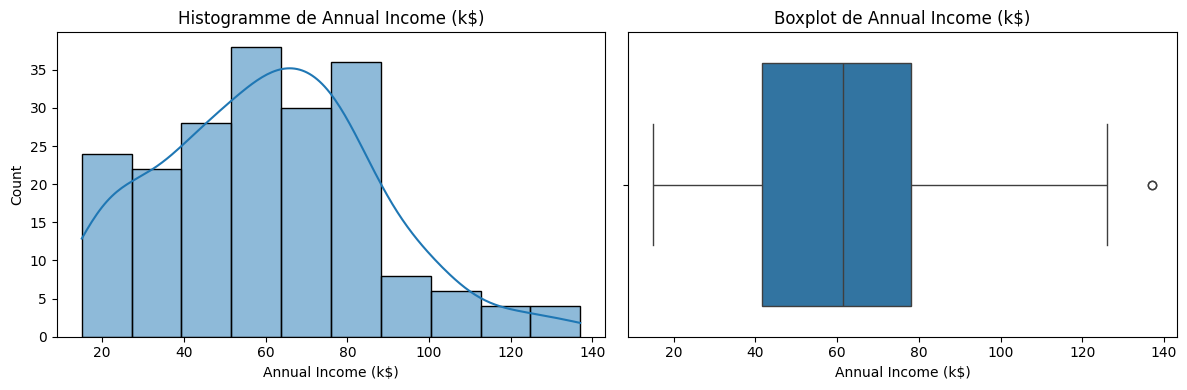

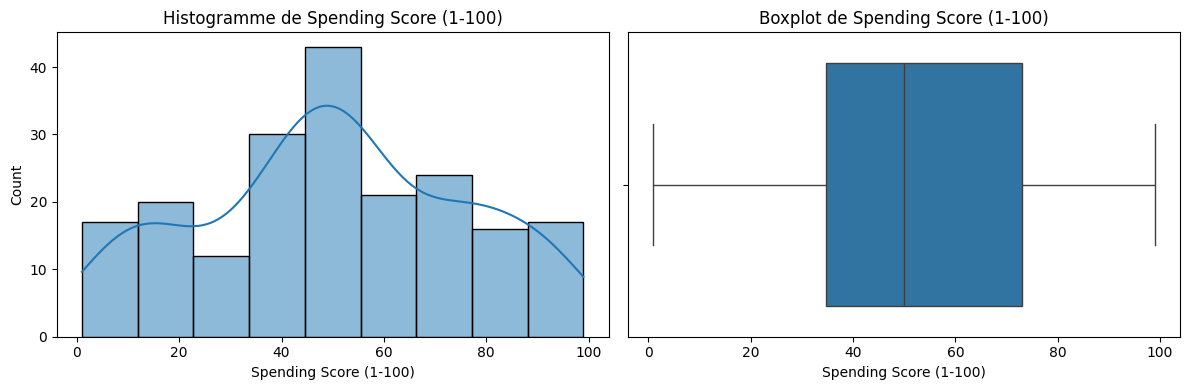

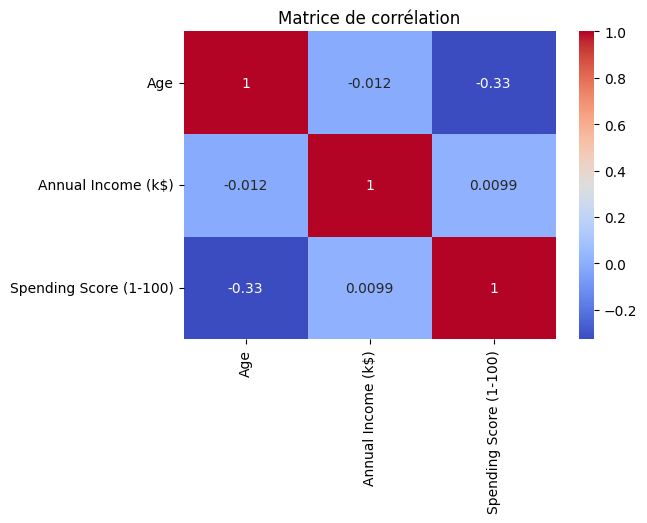

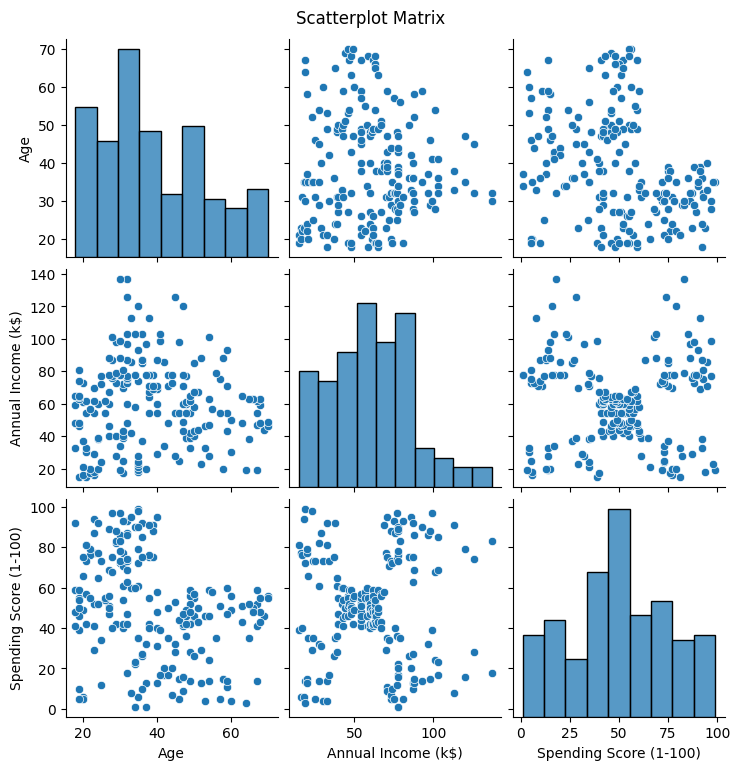

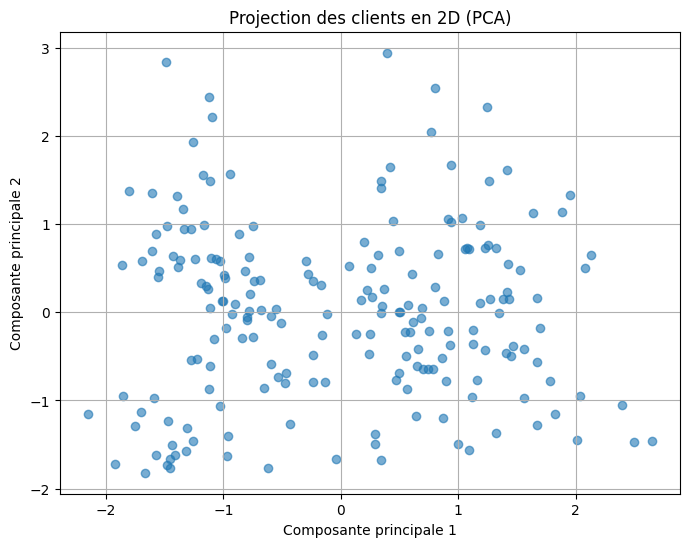

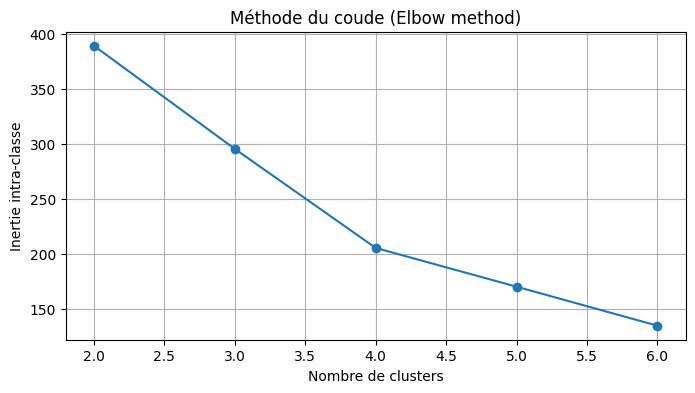

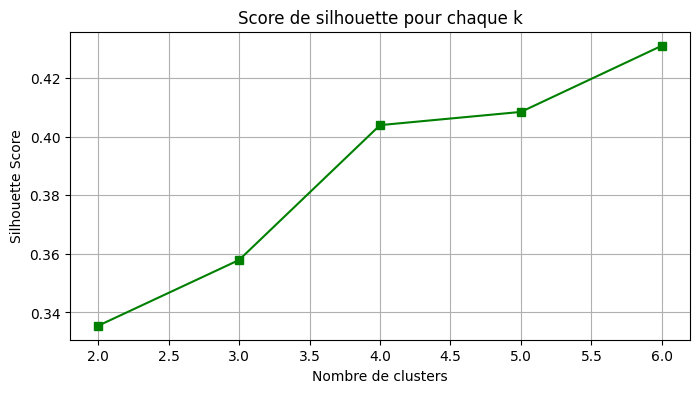

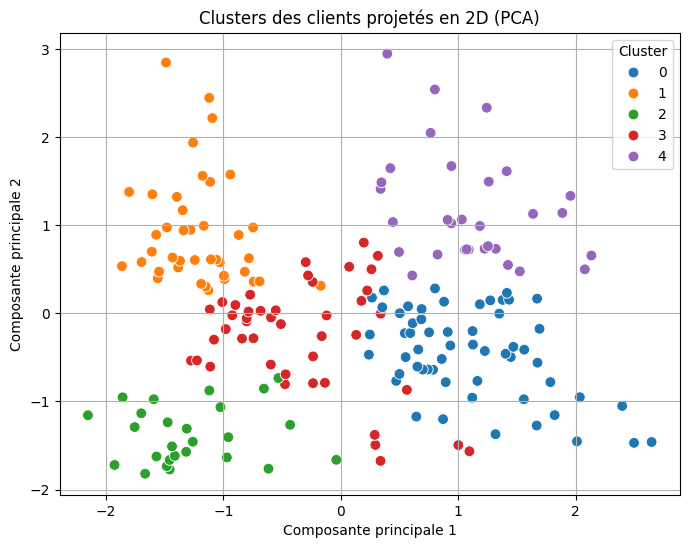


Profils moyens des clusters :
              Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                      
0        1.178830           -0.493886               -0.329716
1       -0.428806            0.974847                1.216085
2       -0.938764           -1.314731                0.956802
3       -0.869573           -0.238517               -0.360609
4        0.397379            1.115089               -1.231270


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Nettoyage, prétraitement, EDA, feature engineering, PCA et clustering
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Chargement des données
df = pd.read_csv("/content/drive/MyDrive/ML/Mall_Customers.csv")

# Affichage des valeurs manquantes
missing = df.isnull().sum()
print("Valeurs manquantes par colonne :\n", missing)

# Suppression de l'identifiant client
df_cleaned = df.drop(columns=['CustomerID'])

# (Optionnel) Catégorisation de l'âge en classes
bins = [0, 20, 35, 50, 70]
labels = ['Adolescent', 'Jeune adulte', 'Adulte', 'Senior']
df_cleaned['AgeGroup'] = pd.cut(df_cleaned['Age'], bins=bins, labels=labels, right=False)

# Encodage de la variable catégorique AgeGroup
df_cleaned = pd.get_dummies(df_cleaned, columns=['AgeGroup'], drop_first=True)

# Standardisation des variables quantitatives
features_to_scale = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_cleaned[features_to_scale])
df_scaled = df_cleaned.copy()
df_scaled[features_to_scale] = scaled_values

print("\nDonnées standardisées et enrichies :")
print(df_scaled.head())

# EDA Univariée : Histogrammes et boxplots
for col in features_to_scale:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f"Histogramme de {col}")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_cleaned[col])
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.show()

# Matrice de corrélation
plt.figure(figsize=(6, 4))
sns.heatmap(df_cleaned[features_to_scale].corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

# Scatterplot matrix
sns.pairplot(df_cleaned[features_to_scale])
plt.suptitle("Scatterplot Matrix", y=1.02)
plt.show()

# PCA pour réduction de dimension et visualisation en 2D
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled.select_dtypes(include=['float64', 'int64']))
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])

# Visualisation des données en 2D via PCA
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], alpha=0.6)
plt.title("Projection des clients en 2D (PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

# Clustering K-Means : évaluation avec Elbow et Silhouette
inertias = []
silhouette_scores = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled.select_dtypes(include=['float64', 'int64']))
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled.select_dtypes(include=['float64', 'int64']), kmeans.labels_))

# Affichage de la méthode du coude (Elbow)
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Méthode du coude (Elbow method)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie intra-classe")
plt.grid(True)
plt.show()

# Affichage des scores silhouette
plt.figure(figsize=(8, 4))
plt.plot(K_range, silhouette_scores, marker='s', color='green')
plt.title("Score de silhouette pour chaque k")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Interprétation finale avec k=5 (choisi selon les graphes)
best_k = 5
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
df_scaled['Cluster'] = final_kmeans.fit_predict(df_scaled.select_dtypes(include=['float64', 'int64']))

# Visualisation des clusters en 2D PCA
df_pca['Cluster'] = df_scaled['Cluster']
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=60)
plt.title("Clusters des clients projetés en 2D (PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Analyse des centroïdes : Profil moyen par cluster
cluster_profiles = df_scaled.groupby('Cluster')[features_to_scale].mean()
print("\nProfils moyens des clusters :")
print(cluster_profiles)

